<a href="https://colab.research.google.com/github/i-SanMartin/FastAI/blob/main/06_Multicat/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 48.2 MB/s 
     |████████████████████████████████| 188 kB 68.8 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 51 kB 274 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

##Data

In [3]:
#Download the data
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
#See the content of the data
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [6]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [7]:
#We have a jpg and a pose txt document for each image
#With this function we obtain the path of a pose doc of a given jpg
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('04/frame_00714_pose.txt')

In [8]:
#Shape of an image
im = PILImage.create(img_files[0])
im.shape

(480, 640)

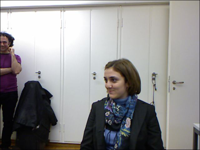

In [9]:
im.to_thumb(200)

In [10]:
#Function to obtain the center of the face in the Biwi dataset
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [11]:
get_ctr(img_files[0])

tensor([368.0074, 259.7773])

In [12]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


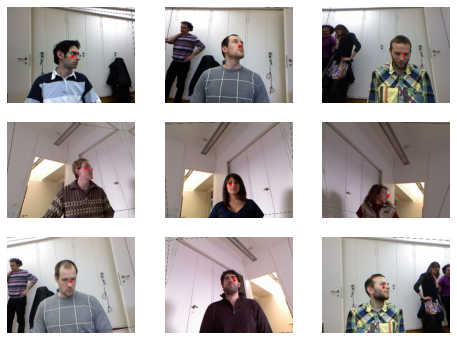

In [13]:
#Independant variables
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [14]:
#Shape of a batch
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [112]:
#The 3 is because it contains 3 images of 240x320 for each color:
image = xb[0].T
image = image.rot90().rot90().rot90()
image.shape

torch.Size([240, 320, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


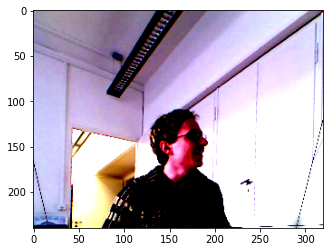

In [113]:
plt.imshow(image)

In [27]:
#Dependat variable
yb[0]

TensorPoint([[-0.0522,  0.1917]])

##Model

In [116]:
#The coordinates in fastai and pytorch are rescalated between -1 and 1,
#so we have to specify the range of the output in y_range
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [117]:
#Fastai implements y_range as:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [118]:
#If we dont specify a loss function fastai chooses one as default
dls.loss_func

FlattenedLoss of MSELoss()